In [1]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [2]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

c:\Users\Maods\Documents\Development\Mestrado\project-tree\Depth-Anything\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
image_1 = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070713.jpg'
image_2 = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070722.jpg'
image_3 = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Camera Celular\20240531_070834.jpg'
image_4 = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240601 Redmi 10 Prime\IMG_20240601_102833.jpg'
image_5 = r'C:\Users\Maods\Documents\Development\Mestrado\project-tree\Imagens Rede Eletrica\240531 Samung A32 - Open Camera\IMG_20240531_075143.jpg'


image = Image.open(image_5).convert("RGB")
texts = [["a photo of a tree"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

c:\Users\Maods\Documents\Development\Mestrado\project-tree\Depth-Anything\venv\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'text'
  return self.preprocess(images, **kwargs)


In [14]:
target_sizes = torch.Tensor([image.size[::-1]])
target_sizes

tensor([[1840., 4080.]])

In [15]:
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo of a tree with confidence 0.341 at location [548.88, -0.71, 2433.05, 1826.74]
Detected a photo of a tree with confidence 0.101 at location [2582.52, 601.6, 2832.72, 752.88]
Detected a photo of a tree with confidence 0.128 at location [2728.96, 4.29, 3442.29, 1833.68]
Detected a photo of a tree with confidence 0.128 at location [563.41, 83.83, 1547.49, 1840.86]


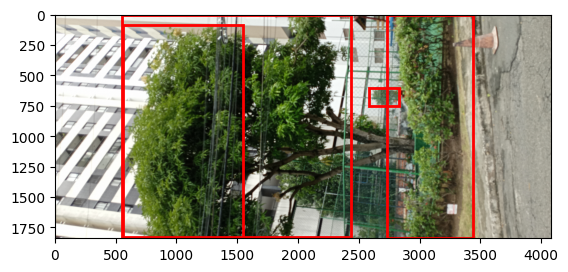

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = image_1


fig, ax = plt.subplots()
ax.imshow(image)

# Iterandoresults sobre os boxes e plotando cada um
for box in results[0]["boxes"].cpu().detach().numpy():
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    
    # Adicionando o bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # break

# Exibindo a imagem
plt.show()

In [17]:
from sam_utils import *

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

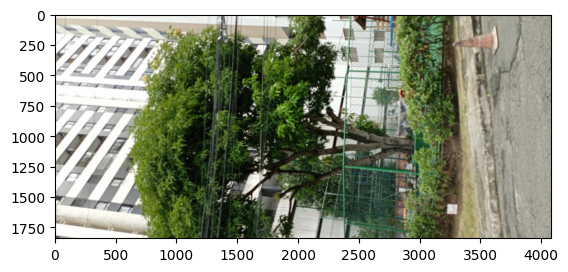

In [20]:
plt.imshow(image)

In [21]:
inputs = processor(image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

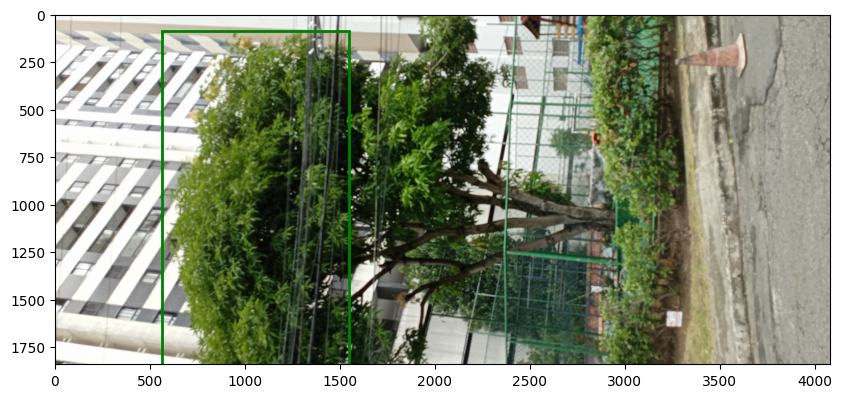

In [ ]:
# input_points = [[[x_min, y_min, x_max, y_max]]]
input_boxes = [[[x_min, y_min]]]

show_boxes_on_image(image, input_boxes[0]) 

In [ ]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

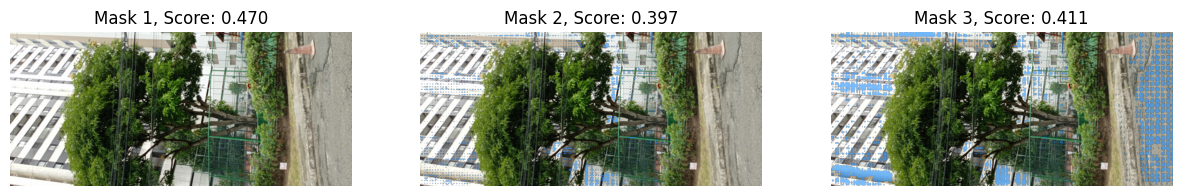

In [28]:
show_masks_on_image(image, masks[1], scores)